In [1]:
###########################################################################################################
"""
Predict the level of solar radiation based on variables such as temperature, pressure, wind direction, etc.
"""
###########################################################################################################

from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import missingno as ms

##Import my Top-k classification module
from top_k_models.classification import *

##For machine learning purposes
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import metrics


In [2]:
##Convert date and time columns to time in seconds
solardata = pd.read_csv('SolarPrediction.csv', parse_dates=['Data'])
solardata['Date_s'] = pd.to_timedelta(solardata['Data']).dt.total_seconds().astype('float')
solardata['Time_s'] = pd.to_timedelta(solardata['Time']).dt.total_seconds().astype('float')
solardata['TimeSunRise_s'] = pd.to_timedelta(solardata['TimeSunRise']).dt.total_seconds().astype('float')
solardata['TimeSunSet_s'] = pd.to_timedelta(solardata['TimeSunSet']).dt.total_seconds().astype('float')
solardata = solardata.drop(['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'],axis=1)

##Print head
solardata.head(5)

/usr/local/lib/python3.7/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)


,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Date_s,Time_s,TimeSunRise_s,TimeSunSet_s
0,1.21,48,30.46,59,177.39,5.62,1.475107e+09,86126.0,22380.0,65580.0
1,1.21,48,30.46,58,176.78,3.37,1.475107e+09,85823.0,22380.0,65580.0
2,1.23,48,30.46,57,158.75,3.37,1.475107e+09,85526.0,22380.0,65580.0
3,1.21,48,30.46,60,137.71,3.37,1.475107e+09,85221.0,22380.0,65580.0
4,1.17,48,30.46,62,104.95,5.62,1.475107e+09,84924.0,22380.0,65580.0


In [3]:
#Print info
#ms.matrix(solardata)
print(solardata.info())
print(solardata.shape)
solardata.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 10 columns):
Radiation                 32686 non-null float64
Temperature               32686 non-null int64
Pressure                  32686 non-null float64
Humidity                  32686 non-null int64
WindDirection(Degrees)    32686 non-null float64
Speed                     32686 non-null float64
Date_s                    32686 non-null float64
Time_s                    32686 non-null float64
TimeSunRise_s             32686 non-null float64
TimeSunSet_s              32686 non-null float64
dtypes: float64(8), int64(2)
memory usage: 2.5 MB
None
(32686, 10)


,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Date_s,Time_s,TimeSunRise_s,TimeSunSet_s
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,3.268600e+04,32686.000000,32686.000000,32686.000000
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,1.477968e+09,43277.574068,23258.431133,64691.463624
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,3.005110e+06,24900.749819,931.122823,995.053346
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,1.472688e+09,1.000000,22020.000000,63720.000000
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,1.475453e+09,21617.000000,22440.000000,63900.000000
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,1.477958e+09,43230.000000,23040.000000,64260.000000
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,1.480378e+09,64849.000000,24000.000000,65340.000000
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,1.483142e+09,86185.000000,25020.000000,67080.000000


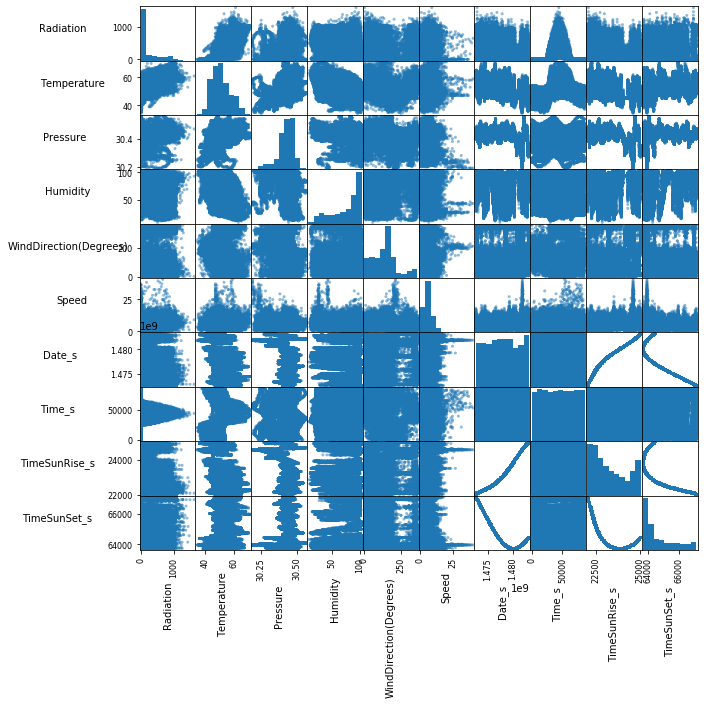

In [10]:
##Corner plot of column data to see correlations between solar radiation and different variables
ax1=pd.plotting.scatter_matrix(solardata, figsize=(10,10))
n = len(solardata.select_dtypes(include=['number']).columns)
for x in range(n):
    for y in range(n):
        ax = ax1[x, y] 
        ax.xaxis.label.set_rotation(90)
        ax.yaxis.label.set_rotation(0)
        ax.yaxis.labelpad = 50
plt.show()

In [5]:
##Divide solar radiation data into 4 radiation levels
solardata['solar_radiation'] = pd.cut(solardata['Radiation'], bins=4, labels = None)
solardata['solar_radiation'].value_counts(dropna=False)

(-0.49, 401.148]       25173
(401.148, 801.185]      4368
(801.185, 1201.222]     3096
(1201.222, 1601.26]       49
Name: solar_radiation, dtype: int64

In [6]:
##Define class and feature data for Top-k model
x = solardata.drop(['Radiation','solar_radiation'], axis=1)
y = solardata['solar_radiation']

#save list of indices before splitting
yinds = arange(y.shape[0]).tolist()

##Split train and test data
x_train, x_test, y_train, y_test, yinds_train, yinds_test = train_test_split(x,y,yinds,test_size=0.25,random_state=10)
print('Training set size: ', x_train.shape, y_train.shape)
print('Test set size:', x_test.shape, y_test.shape)

Training set size:  (24514, 9) (24514,)
Test set size: (8172, 9) (8172,)


In [7]:
##Transform the numerical data
##Normalise the variables to the same level of magnitude by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaler.fit(x_train)
x_train_trans = scaler.transform(x_train)
x_test_trans = scaler.transform(x_test)

#Transform the solar radiation categorical data by converting the categories into numerical dummy variables.
yencoder = LabelEncoder()
yencoder.fit(y_train)
y_train_trans = yencoder.transform(y_train)
y_test_trans = yencoder.transform(y_test)

print(x_train_trans.shape, x_test_trans.shape)

(24514, 9) (8172, 9)


In [8]:
##No. of Top-k matches 
n_pred = 2

## 3 models to test
m1 = KNeighborsClassifier(n_neighbors=7)
m2 = GaussianNB()
m3 = LogisticRegression(random_state=0,solver='newton-cg',multi_class='multinomial')
k_models = [m1,m2,m3]

##Calculate Top-k accuracy using the 3 classifiers
y_pred, p_res, class_sort, prob_sort = \
                topk_performance(k_models[0],n_pred,x_train_trans,y_train_trans,x_test_trans,y_test_trans,yencoder)
print('')

##Calculate the best model out of the 3 and return results from the best model
ypred_max, p_res_max, class_sort_max, prob_sort_max = \
                    best_topk_model(k_models,n_pred,x_train_trans,y_train_trans,x_test_trans,y_test_trans,yencoder)


##Compare solar radiation level to the Top-k predictions from the best model
df_class_max = pd.DataFrame(data=class_sort_max,columns=['Rank 2', 'Rank 1'])
y_comp = pd.concat([df_class_max,y_test.reset_index(drop=True)],axis=1)
y_comp.head(20)


Performance KNeighborsClassifier: [('PPV Rank 2', 0.07794909446891858), ('PPV Rank 1', 0.8953744493391238), ('Top-2 accuracy', 0.9733235438080309)]


Performance KNeighborsClassifier: [('PPV Rank 2', 0.07794909446891858), ('PPV Rank 1', 0.8953744493391238), ('Top-2 accuracy', 0.9733235438080309)]

Performance GaussianNB: [('PPV Rank 2', 0.09728340675477214), ('PPV Rank 1', 0.8628242780224373), ('Top-2 accuracy', 0.9601076847771958)]

Performance LogisticRegression: [('PPV Rank 2', 0.11784140969162908), ('PPV Rank 1', 0.8370044052862687), ('Top-2 accuracy', 0.9548458149778818)]

Best model: KNeighborsClassifier, [('PPV Rank 2', 0.07794909446891858), ('PPV Rank 1', 0.8953744493391238), ('Top-2 accuracy', 0.9733235438080309)]



,Rank 2,Rank 1,solar_radiation
0,"(1201.222, 1601.26]","(-0.49, 401.148]","(-0.49, 401.148]"
1,"(401.148, 801.185]","(801.185, 1201.222]","(801.185, 1201.222]"
2,"(1201.222, 1601.26]","(-0.49, 401.148]","(-0.49, 401.148]"
3,"(1201.222, 1601.26]","(-0.49, 401.148]","(-0.49, 401.148]"
4,"(1201.222, 1601.26]","(-0.49, 401.148]","(-0.49, 401.148]"
5,"(1201.222, 1601.26]","(-0.49, 401.148]","(-0.49, 401.148]"
6,"(1201.222, 1601.26]","(-0.49, 401.148]","(-0.49, 401.148]"
7,"(1201.222, 1601.26]","(-0.49, 401.148]","(-0.49, 401.148]"
8,"(1201.222, 1601.26]","(-0.49, 401.148]","(-0.49, 401.148]"
9,"(1201.222, 1601.26]","(-0.49, 401.148]","(-0.49, 401.148]"
